## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1. Compute the camera calibration and Undistort the images

In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

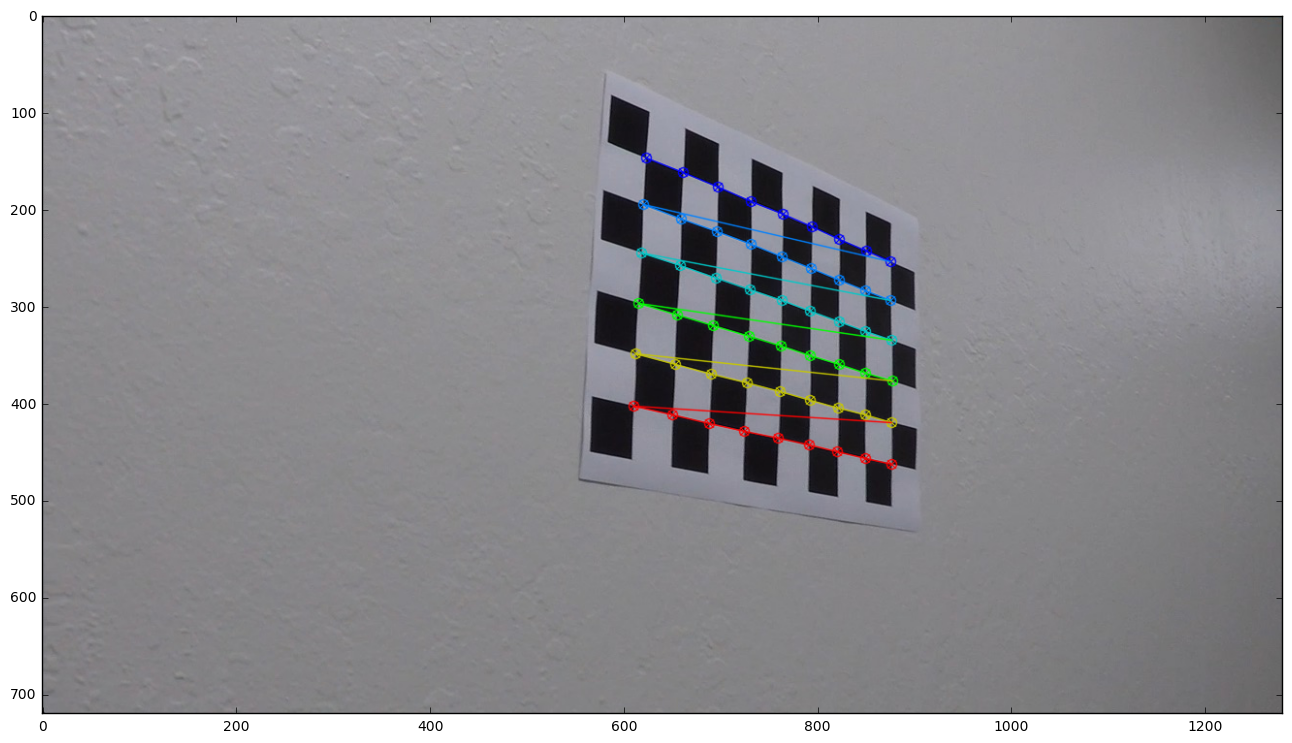

In [4]:
#################### Chessboard Corner_find function ####################
def corner_find(images):
    #Array for Object Points and Image Points 
    objpoints=[] #3D points in real world space
    imgpoints=[] #2D points in image plane

    #Prepare the Object Points (9 by 6 images)
    objp = np.zeros((6*9,3),np.float32)
    objp[:,:2]=np.mgrid[0:9,0:6].T.reshape(-1,2)

    for fname in images:

        #Read an image
        img=mpimg.imread(fname)
    
        #Convert the Image to Gray Scale
        gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

        #Find the Chessboard Corners
        ret, corners=cv2.findChessboardCorners(gray, (9,6), None)

        #If corners are found, add object points, image points
        if ret == True: 
            objpoints.append(objp)
            #Refine the subpix corners 
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 0.1)
            corner_refine=cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
            imgpoints.append(corner_refine)
    
            #Chessboard corner example
            chessboardimg=cv2.drawChessboardCorners(img, (9,6), corner_refine, ret)
    
    return objpoints, imgpoints, chessboardimg
        
        

##################### Display a smaple chessboard corner image ####################
images = glob.glob('./camera_cal/calibration*.jpg')
objpoints, imgpoints, chessboardimg = corner_find(images)
plt.figure(figsize=(24,9))
plt.imshow(chessboardimg)

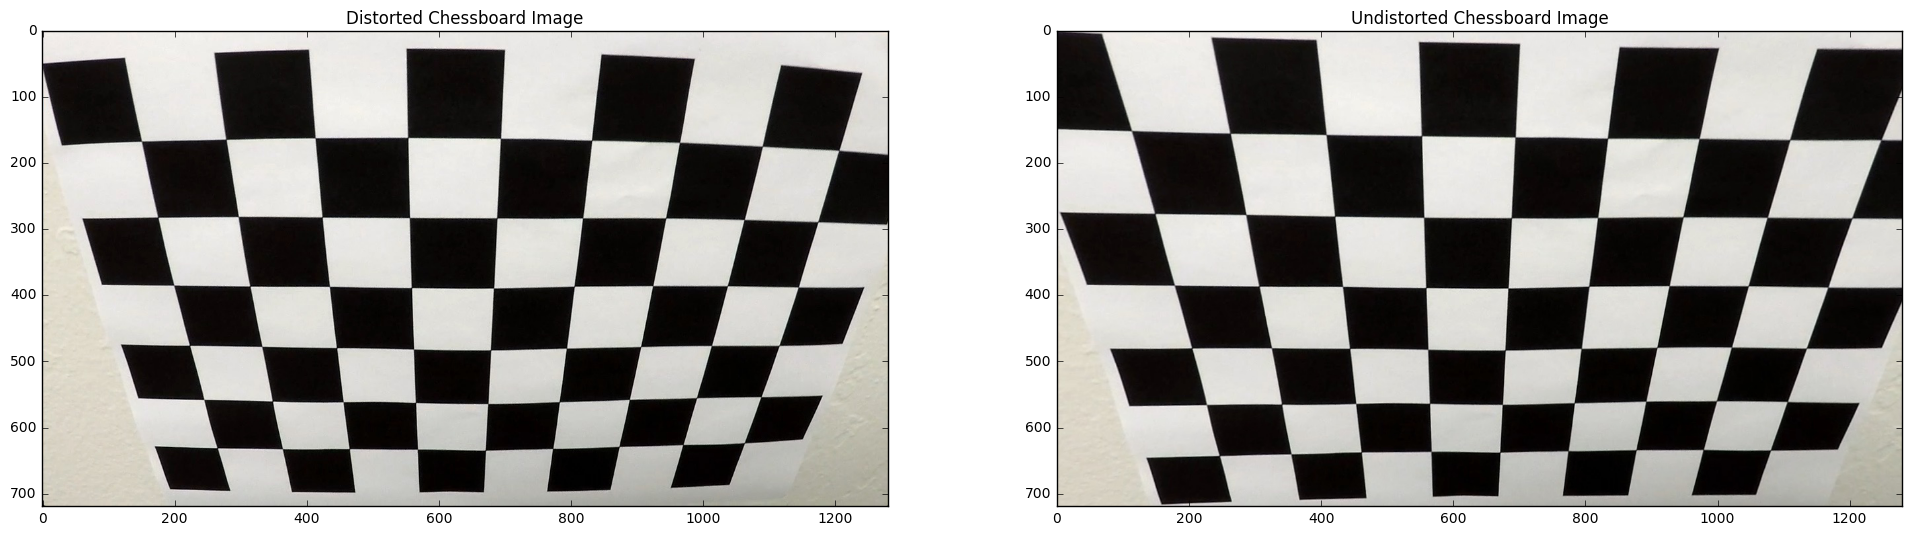

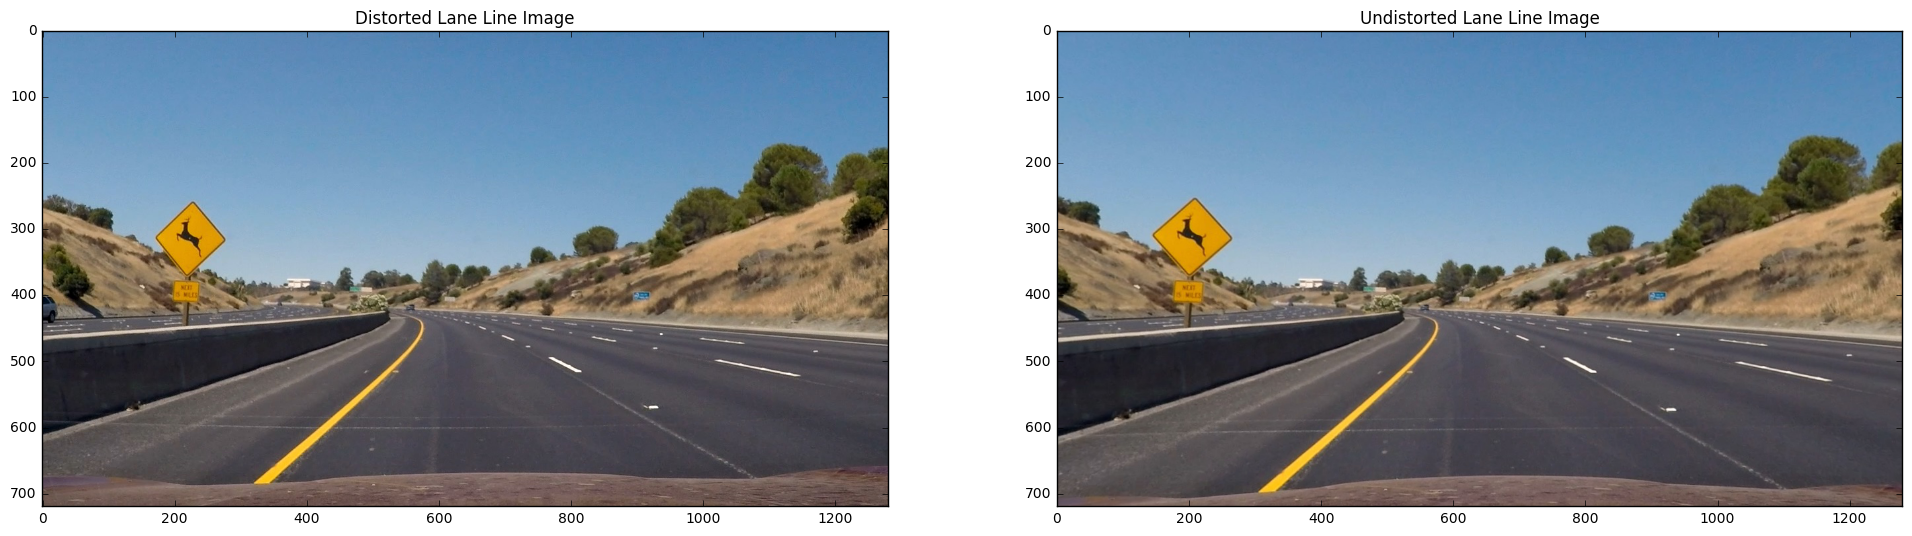

In [5]:
##################### undistort image function #####################
def undistort_image(img, objpoints, imgpoints):
    img_size=(img.shape[1], img.shape[0])
    # Camera calibration & undistortion of the image 
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undistort = cv2.undistort(img, mtx, dist, None, mtx)
    return undistort


##################### Read a sample cheassboard image & undistort it #####################
img_chess=mpimg.imread('./camera_cal/calibration2.jpg')
img_chess_undistort=undistort_image(img_chess, objpoints, imgpoints)

plt.figure(figsize=(24,9))
plt.subplot(1, 2, 1)
plt.imshow(img_chess)
plt.title("Distorted Chessboard Image")
plt.subplot(1, 2, 2)
plt.imshow(img_chess_undistort)
plt.title("Undistorted Chessboard Image")

plt.imsave("output_images/Undistort_ChessboardSample.jpg",img_chess_undistort)

##################### Read a test image & undistort it #####################
img_test=mpimg.imread('./test_images/test2.jpg')
img_test_undistort=undistort_image(img_test, objpoints, imgpoints)

plt.figure(figsize=(24,9))
plt.subplot(1, 2, 1)
plt.imshow(img_test)
plt.title("Distorted Lane Line Image")
plt.subplot(1, 2, 2)
plt.imshow(img_test_undistort)
plt.title("Undistorted Lane Line Image")

plt.imsave("output_images/Undistorted_test2.jpg",img_test_undistort)

## 2. Perspective Transform for Original Image

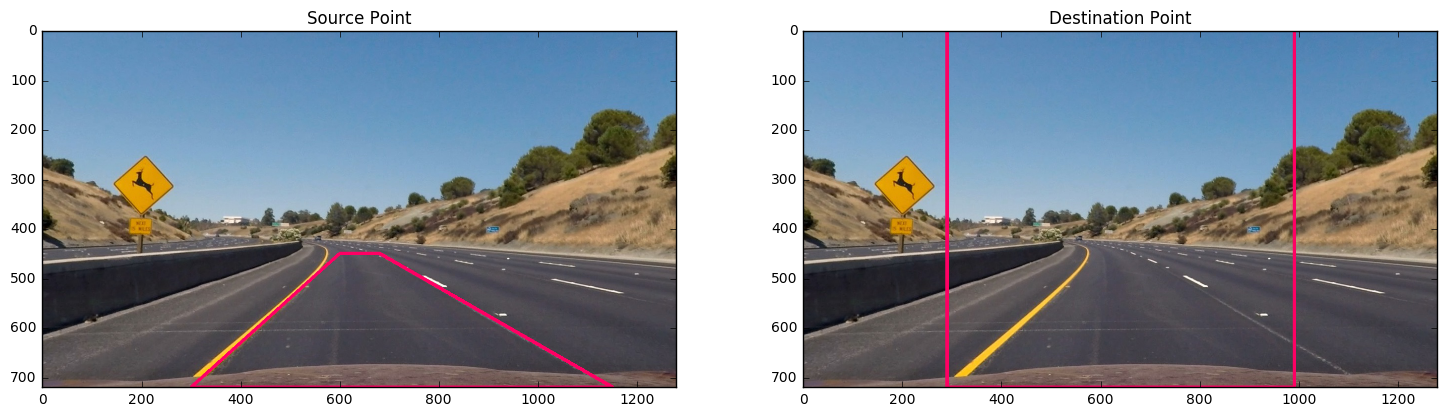

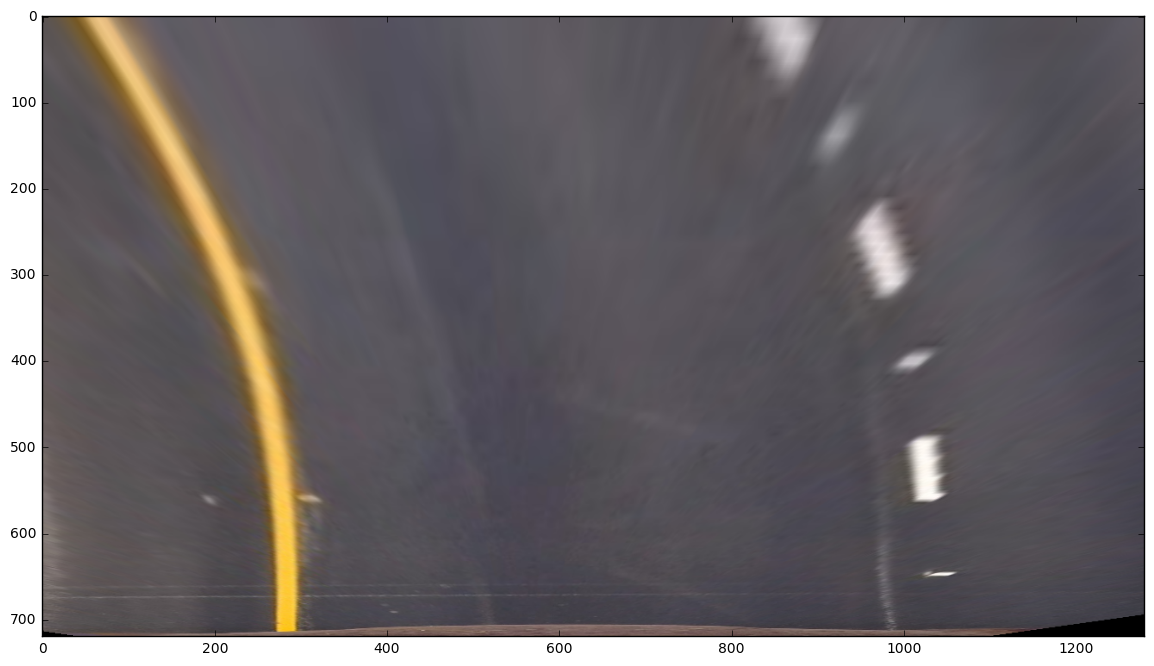

In [6]:
##################### perspective Transform Function #####################
def perspective_transform(img):
    
    #Image size (Height & Width)
    img_size=(img.shape[1],img.shape[0])
    height=img.shape[0]
    width=img.shape[1]
    #Four source coordinate (Used image height & width)
    src=np.float32([[width/2-40,height/2+90],[300,height],[1150,height],[width/2+40,height/2+90]])
    dst=np.float32([[width/2-350,0],[width/2-350,height],[width/2+350,height],[width/2+350,0]])
    
    #Calculate Perspective Transform Matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    #Calculate Inverse Perspective Transform Matrix (To use when re-mapping image)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    #Warp the image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return src, dst, warped, M, Minv 

##################### Show Four Coordinate and Warped Image #####################
Test_img_src=mpimg.imread('output_images/Undistorted_test2.jpg')
Test_img_dst=Test_img_src.copy()
#Find src & dest point 
src, dst, warped_image = perspective_transform(Test_img_src)[0:3]
src=src.reshape((-1, 1, 2)).astype("int32")
dst=dst.reshape((-1, 1, 2)).astype("int32")
#Draw the points on the image
cv2.polylines(Test_img_src,[src],True,(255,0,100),thickness=6)
cv2.polylines(Test_img_dst,[dst],True,(255,0,100),thickness=6)

#Show the coordinate points and warped image
plt.figure(figsize=(18,8))
plt.subplot(1, 2, 1)
plt.imshow(Test_img_src)
plt.title("Source Point")
plt.subplot(1, 2, 2)
plt.imshow(Test_img_dst)
plt.title("Destination Point")    

plt.figure(figsize=(18,8))
plt.imshow(warped_image)

plt.imsave("output_images/Warped_color_test2.jpg",warped_image)

## 3. Create Threshold Binary Image for Lane Detection

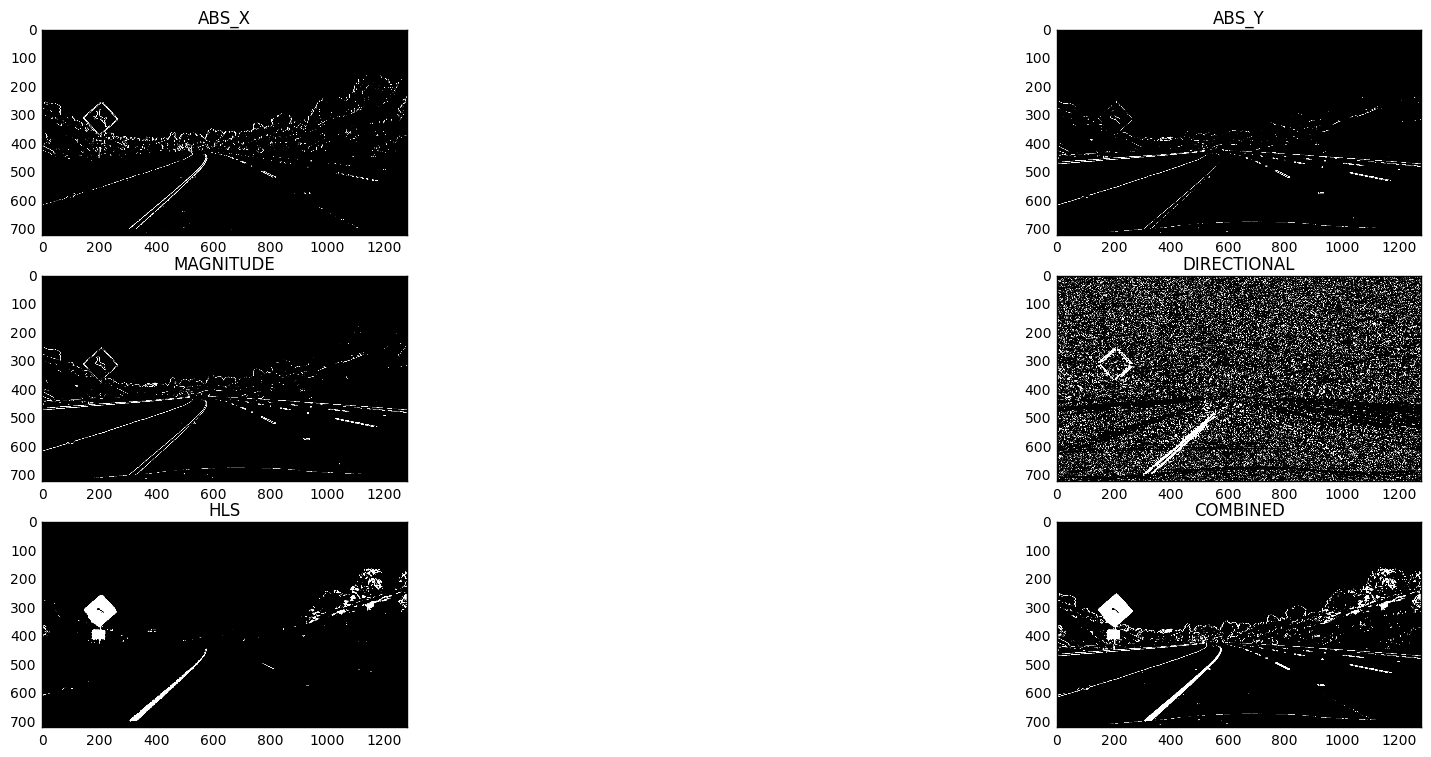

In [7]:
##################### Create Threshold Binary Image #####################
##################### 1. ABS Sobel Function #####################
def abs_sobel(img, orient='x',abs_thresh=(20, 100)):
    # Take a gray scale image 
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # Take a derivative x or y  
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Scale to 8-Bit
    scaled_sobel=np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Calculate binary output
    binary_output=np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel>=abs_thresh[0])&(scaled_sobel<=abs_thresh[1])]=1
    
    return binary_output

##################### 2. Magnitude Sobel Function #####################
def mag_sobel(img, sobel_kernel=3, mag_thresh=(30, 200)):
    # Take a gray scale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    return binary_output

##################### 3. Directional Sobel Function #####################
def dir_sobel(img, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
    # Take a gray scale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1

    return binary_output

##################### 4. HLS Select Function (Use S Channel only) #####################
def hls_select(img, hls_thresh=(0, 255)):
    # Take a S Channel image 
    hls=cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel=hls[:,:,2]
    # Create a binary image
    binary_output=np.zeros_like(s_channel)
    binary_output[(s_channel>hls_thresh[0])&(s_channel<=hls_thresh[1])]=1
    
    return binary_output


##################### Show each binary images & Combined image  #####################
def combined_binary(img):
    abs_x_binary=abs_sobel(img, orient='x', abs_thresh=(40,255))
    abs_y_binary=abs_sobel(img, orient='y', abs_thresh=(70,255))
    mag_binary=mag_sobel(img, mag_thresh=(70,255))
    dir_binary=dir_sobel(img, sobel_kernel=15, dir_thresh=(0.7,1,3))
    hls_binary=hls_select(img, hls_thresh=(120,255))
    # I discared "dir_y_binary" information because it includes too much noise even with 
    # clear lane-line infomation 
    # "abs_x", "abs_y", "mag" mainly are used to find the right lane information
    # Otherwise, "hls" gives a big contribution to find left lane information
    combined=np.zeros_like(abs_x_binary)
    combined[(abs_x_binary == 1)|(abs_y_binary == 1)|(mag_binary == 1)|(hls_binary == 1)] = 1
    
    return abs_x_binary, abs_y_binary, mag_binary, dir_binary, hls_binary, combined

##################### Show each binary images & Combined image  #####################
img=mpimg.imread('output_images/Undistorted_test2.jpg')
abs_x_binary, abs_y_binary, mag_binary, dir_binary, hls_binary, combined = combined_binary(img)
plt.figure(figsize=(24,9))
plt.subplot(3, 2, 1)
plt.imshow(abs_x_binary, cmap='gray')
plt.title("ABS_X")
plt.subplot(3, 2, 2)
plt.imshow(abs_y_binary, cmap='gray')
plt.title("ABS_Y")
plt.subplot(3, 2, 3)
plt.imshow(mag_binary, cmap='gray')
plt.title("MAGNITUDE") 
plt.subplot(3, 2, 4)
plt.imshow(dir_binary, cmap='gray')
plt.title("DIRECTIONAL") 
plt.subplot(3, 2, 5)
plt.imshow(hls_binary, cmap='gray')
plt.title("HLS") 
plt.subplot(3, 2, 6)
plt.imshow(combined, cmap='gray')
plt.title("COMBINED") 

plt.imsave("output_images/Threshold_binary_Test2.jpg",combined, cmap=plt.cm.gray)

## 4. Perspective Transform for Binary Image

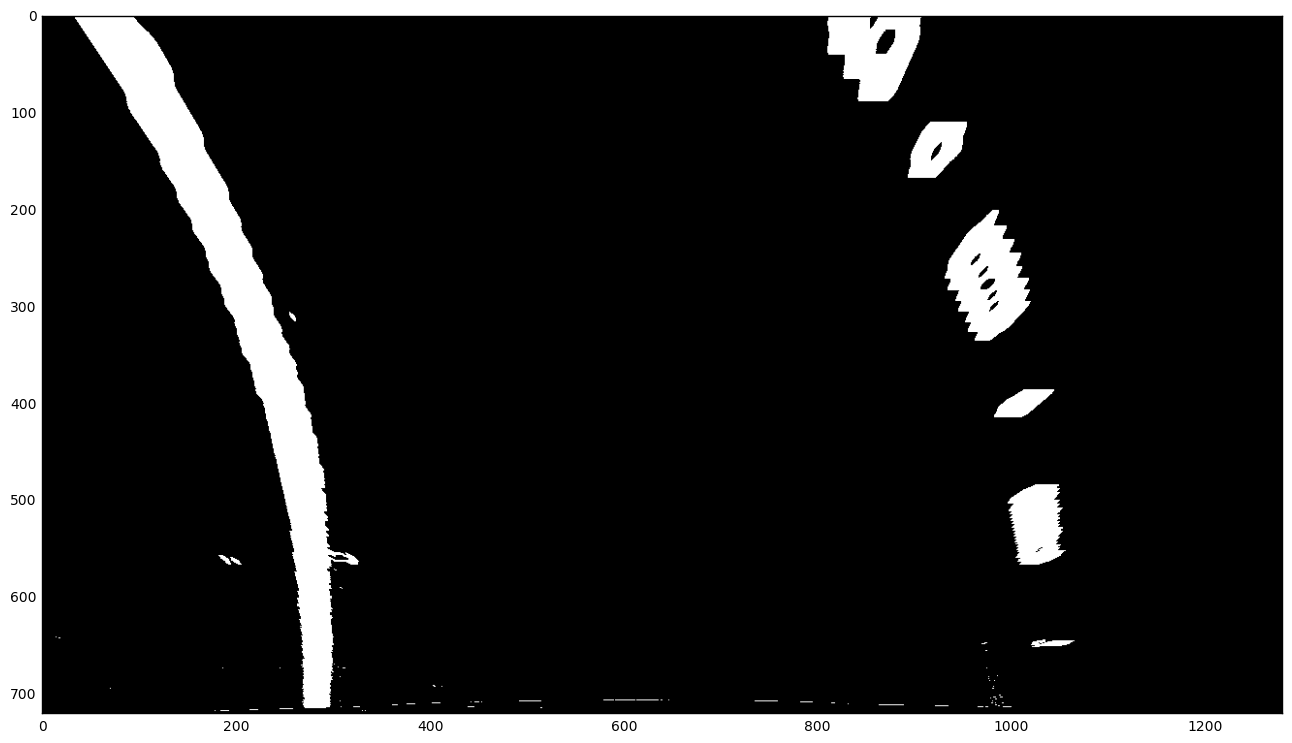

In [8]:
##################### Show binary warped image ##################### 
#Perspective Tranform of combined binary image
warped_image = perspective_transform(combined)[2]
#Display the warped binary image
plt.figure(figsize=(24,9))
plt.imshow(warped_image, cmap='gray')

plt.imsave("output_images/Warped_binary_Test2.jpg",warped_image, cmap=plt.cm.gray)

## 5. Draw Histogram to Find the Lane Position

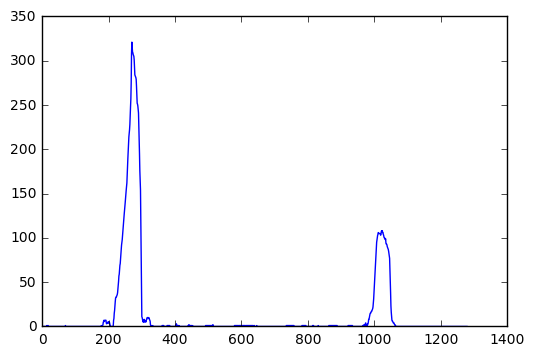

In [9]:
##################### Extract pixel distribution to find the lane start point ##################### 
histogram = np.sum(warped_image[warped_image.shape[0]//2:,:],axis=0)
plt.plot(histogram)

## 6. Implement Lane Fitting Funtion 

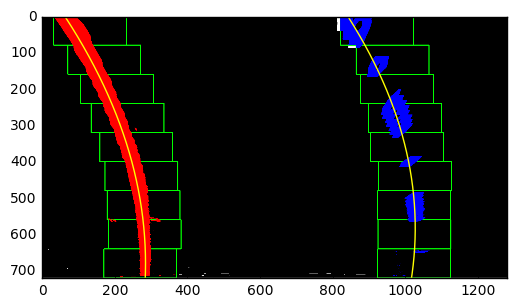

In [10]:
##################### Implement sliding_windows & polynomial fitting ##################### 
def line_fitting(warped_image):
    histogram = np.sum(warped_image[warped_image.shape[0]//2:,:],axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((warped_image, warped_image, warped_image))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped_image.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_image.shape[0] - (window+1)*window_height
        win_y_high = warped_image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) 
                          & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) 
                           & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds

##################### Visualization ##################### 
# Generate x and y values for plotting
left_fit, right_fit, out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds = line_fitting(warped_image)
ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Display image with sliding windows & polynomial fitting line
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig('output_images/line_fitting_Test2.jpg')

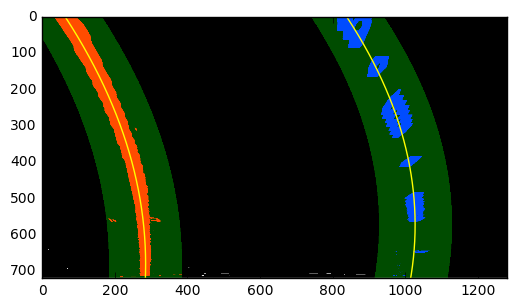

In [19]:
##################### Line fitting from previous frame ##################### 
def line_fitting_prev(warped_image, left_fit, right_fit):
    # Find the lane using previous frame information within fixed margin 
    nonzero = warped_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                      & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                       & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Can't find the lane withing the band, Go back to "Line_Fitting" again
    if len(lefty) < 50 or len(righty) < 50:
        lanefind = False
    else:
        lanefind = True
    
    return lanefind, left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds 

##################### Visualize #####################     
left_fit_p, right_fit_p, nonzerox_p, nonzeroy_p, left_lane_inds_p, right_lane_inds_p = line_fitting_prev(warped_image, left_fit, right_fit)[1:]
# Generate x and y values for plotting
ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0] )
left_fitx = left_fit_p[0]*ploty**2 + left_fit_p[1]*ploty + left_fit_p[2]
right_fitx = right_fit_p[0]*ploty**2 + right_fit_p[1]*ploty + right_fit_p[2]
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((warped_image, warped_image, warped_image))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy_p[left_lane_inds_p], nonzerox_p[left_lane_inds_p]] = [255, 0, 0]
out_img[nonzeroy_p[right_lane_inds_p], nonzerox_p[right_lane_inds_p]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# Recast the x and y points into usable format for cv2.fillPoly()
margin=100
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig('output_images/line_fitting_prev_Test2.jpg')

## 7. Calculate Curvature & Vehicle Offset

In [20]:
##################### Calculate curvature of lane ##################### 
def cal_curvature(left_lane_inds, right_lane_inds, nonzerox, nonzeroy):
    # Maximum number of y value (Bottom of the image)
    y_eval = 719
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad,right_curverad

##################### Print curvature of lane ##################### 
left_curverad,right_curverad = cal_curvature(left_lane_inds, right_lane_inds, nonzerox, nonzeroy)

# Curvature in meters
print(left_curverad, 'm', right_curverad, 'm')


##################### Calculate vehicle offset ##################### 
def cal_vehicle_offset(img, left_fit, right_fit):
    
    #Calculate Lane Deviaction from center of lane
    #Caculate the intercept point of the image, calcuate lane deviation 
    
    height=img.shape[0]
    width=img.shape[1]
    left_lane_intercept=left_fit[0]*(height**2) + left_fit[1]*height + left_fit[2]
    right_lane_intercept=right_fit[0]*(height**2) + right_fit[1]*height + right_fit[2]
    vehicle_offset = width/2 - (left_lane_intercept+right_lane_intercept)/2
    xm_per_pix = 3.7/700
    vehicle_offset *= xm_per_pix
    
    return vehicle_offset

##################### Print vehicle offset ##################### 
vehicle_offset = cal_vehicle_offset(img, left_fit, right_fit)
print(vehicle_offset, 'm')

342.85941609 m 301.051728318 m
-0.0531616023977 m


## 8. Lane Drawing Function 

In [21]:
##################### draw_lanes ##################### 
def draw_lanes(warped_image, image, left_fit, right_fit, Minv, left_curverad, right_curverad, vehicle_offset):
    
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Create a blank image to draw the lines on
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    curvature_text = "Curvature: Left = " + str(np.round(left_curverad, 2)) + ", Right = " + str(np.round(right_curverad, 2)) 
    font = cv2.FONT_ITALIC
    cv2.putText(result, curvature_text, (30, 60), font, 1, (255,255,255), 2)
    deviation_text = "Lane deviation from center = {:.2f} m".format(vehicle_offset) 
    font = cv2.FONT_ITALIC 
    cv2.putText(result, deviation_text, (30, 90), font, 1, (255,255,255), 2)
        
    return result


## 9. Line() Class for Smoothing the lane

In [22]:
##################### Line class for Smoothing ##################### 
class Line():
    def __init__(self, n_smooth): 
        # Number of averaging size
        self.n_smooth=n_smooth
        # Initial polynomial coefficient A*y**2+B*y+C
        self.A=[]
        self.B=[]
        self.C=[] 
        # Initial Average 
        self.A_ave=np.float32(0.0)
        self.B_ave=np.float32(0.0)
        self.C_ave=np.float32(0.0)
        
    def return_average(self):
        #return calculated average
        return (self.A_ave, self.B_ave, self.C_ave)
    
    def cal_average(self, fit):
        # Append coefficient 
        self.A.append(fit[0])
        self.B.append(fit[1])
        self.C.append(fit[2])
        
        # Exceed number of averaging size? 
        if len(self.A) > self.n_smooth:
            self.A.pop(0)
            self.B.pop(0)
            self.C.pop(0)
        else:
            pass
                
        # Averaging the coefficient 
        self.A_ave=np.mean(self.A)
        self.B_ave=np.mean(self.B)
        self.C_ave=np.mean(self.C)
        
        return (self.A_ave, self.B_ave, self.C_ave)

## 10. Pipeline for "Advanced Lane Finding"

In [23]:
##################### Image/Video Process pipeline ##################### 
def pipeline(image):
    #Undistort, Detect binary image, perspective transform
    undistorted = undistort_image(image, objpoints, imgpoints)
    binary_image = combined_binary(undistorted)[5]
    src, dst, warped_image, M, Minv = perspective_transform(binary_image)
    global detect
    
    #If first lane detection, 
    if detect == False:
        left_fit, right_fit, out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds = line_fitting(warped_image)
        
        left_fit=left_line.cal_average(left_fit)
        right_fit=right_line.cal_average(right_fit)
        left_curverad,right_curverad = cal_curvature(left_lane_inds, right_lane_inds, nonzerox, nonzeroy)
        vehicle_offset = cal_vehicle_offset(image, left_fit, right_fit)
        detect = True
    
    else: 
        left_fit=left_line.return_average()
        right_fit=right_line.return_average()
        lanefind, left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds = line_fitting_prev(warped_image, left_fit, right_fit)
        
        if lanefind == True:
            left_fit=left_line.cal_average(left_fit)
            right_fit=right_line.cal_average(right_fit)
            left_curverad,right_curverad = cal_curvature(left_lane_inds, right_lane_inds, nonzerox, nonzeroy)
            vehicle_offset = cal_vehicle_offset(image, left_fit, right_fit)
        else:
            detect = False
            left_fit=left_line.return_average()
            right_fit=right_line.return_average()
    
    result = draw_lanes(warped_image, image, left_fit, right_fit, Minv, left_curverad, right_curverad, vehicle_offset) 
    
    return result
    

## 11. Image/Video Processing 

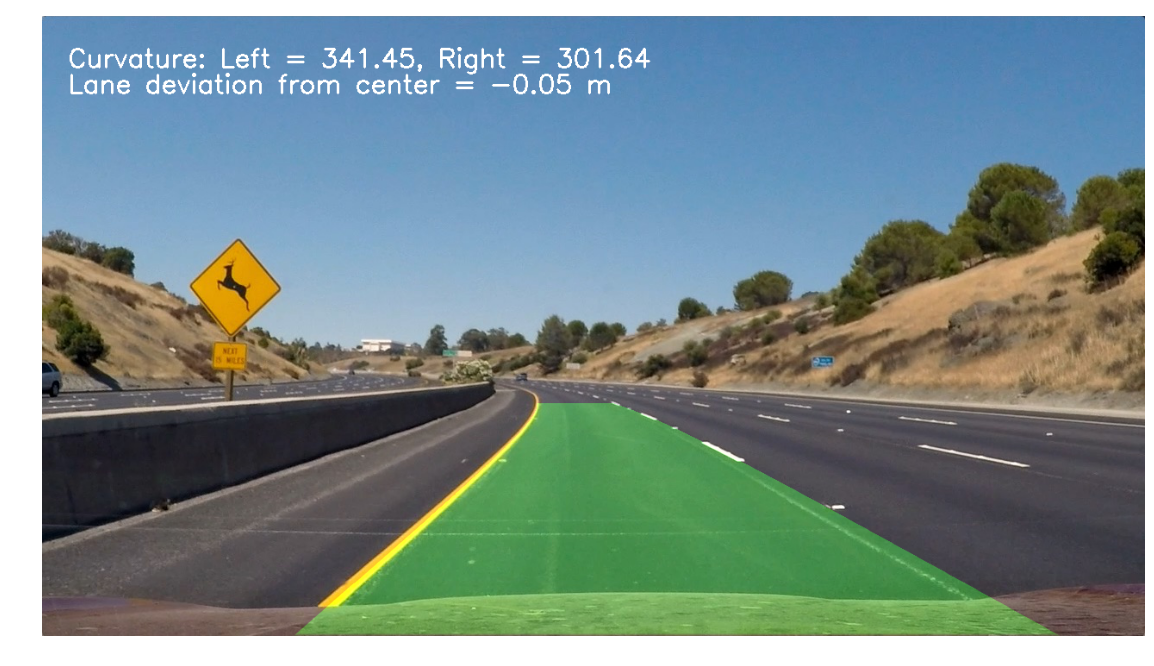

In [24]:
##################### Image Process ##################### 
detect = False
left_line=Line(n_smooth=9)
right_line=Line(n_smooth=9)
# Run on a test image
image = mpimg.imread('./test_images/test2.jpg')

result = pipeline(image)

plt.figure(figsize=(16,8))
plt.imshow(result)
plt.axis("off");

plt.imsave("output_images/Warped_back_Test2.jpg",result)

In [25]:
##################### Video Process ##################### 
from moviepy.editor import VideoFileClip
video_output = "output_images/Warped_back_video_output.mp4"
video = VideoFileClip("project_video.mp4")
output = video.fl_image(pipeline) 
%time output.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/Warped_back_video_output.mp4
[MoviePy] Writing video output_images/Warped_back_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:48<00:00,  3.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/Warped_back_video_output.mp4 

Wall time: 5min 49s
